**Ejercicio:** 
- Complete la implementación de `myMLP`, construya una red neuronal completamente conectada con una capa oculta
- Entrene su red por 1000 épocas usando Adam, proponga un criterio para detener el entrenamiento de la red que ayude a evitar el sobreajuste. Justifique

<b> Respuesta: </b> Para evitar sobreajuste se comparan los errores sobre training y testing data, en donde si es que superan cierto valor definido, entonces se detiene la iteración. Esto se justifica ya que si se tiene sobreajuste, entonces el error sobre el conjunto de datos de entrenamiento comienza a disminuir y para el caso del conjunto de testing comienza a aumentar.

- Haga pruebas con un tamaño de minibatch de entrenamiento de 1, 32 y 256 ¿Qué diferencias nota? Justifique

<b> Respuesta: </b> La variable batchsize setea el número de instancias que se utilizan por cada iteración por cada epoch, por lo que a menor valor de batchsize, mas iteraciones se realizan por epoch. 
Al considerar un tamaño de 1 se tiene un tiempo de ejecuciónd de 5min 8s (utilizando magic %time). Al considerar un valor de 32 se tiene un tiempo de ejecución de 55.5 s, y para 256 se tiene un tiempo de 1min 14s.
El menor tiempo para 32 posiblemente se deba a que con ese tamaño, el conjunto de datos puede ser alocado en memoria caché, sin embargo para un tamaño de 256 probablemente no pueda ser alocado completamente en memoria caché.

- Experimente con los datasets *two moons* y *blobs* usando distinto número de neuronas en la capa oculta y distintas funciones de activación ¿Qué diferencias puede reportar?

<b> Respuesta: </b>  Usando Relu, se obtuvo que a mayor número de neuronas en la capa oculta se obtienen menores valores de la función costo, por lo que el modelo es capaz de predecir correctamente las clases a medida que se aumenta el número de neuronas. Por otro lado, el acurracy aumenta al aumentar el número de neuronas.

(De lo anterior, se tiene que a mayor número de neuronas se tiene menor error).

Al comparar funciones de activación, se tienen diferentes valores de accuracy, por ejemplo, al comparar RELU con Sigmoid, se tiene que, para la misma arquitectura (número de capas y neuronas), RELU obtiene mayor accuracy.

Al comparar para el conjunto de datos (two moons y blobs), se tiene que se requieren mayor número de neuronas para separar blobs debido a la naturaleza de su distribución.

- Opcional: Modifique el entrenamiento para correr en GPU. 

Para correr en GPU se envia el modelo y los datos de training y test a GPU durante entrenamiento.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
# Crear conjuntos de entrenamiento y prueba
from torch.utils.data import DataLoader, TensorDataset, Subset 

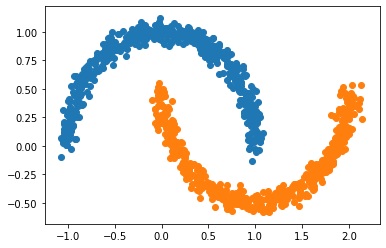

In [64]:
# get data
# data, labels = sklearn.datasets.make_circles(n_samples=1000, noise=0.2, factor=0.25)
data, labels = sklearn.datasets.make_moons(n_samples=1000, noise=0.05)
# data, labels = sklearn.datasets.make_blobs(n_samples=[250]*4, n_features=2, cluster_std=0.1,centers=np.array([[-1, 1], [1, 1], [-1, -1], [1, -1]]))

labels[labels==2] = 1; labels[labels==3] = 0;                                        

# get train and test idx
train_idx, test_idx = next(sklearn.model_selection.ShuffleSplit(train_size=0.5).split(data, labels))

# plot data
fig, ax = plt.subplots()
ax.scatter(data[labels == 0, 0], data[labels == 0, 1])
ax.scatter(data[labels == 1, 0], data[labels == 1, 1])

In [65]:
torch_set = TensorDataset(torch.from_numpy(data.astype('Float32')), 
                          torch.from_numpy(labels.astype('Float32')))

# torch_train_loader = DataLoader(Subset(torch_set, train_idx), shuffle=True, batch_size = 1)
torch_train_loader = DataLoader(Subset(torch_set, train_idx), shuffle=True, batch_size = 32)
# torch_train_loader = DataLoader(Subset(torch_set, train_idx), shuffle=True, batch_size = 256)
torch_valid_loader = DataLoader(Subset(torch_set, test_idx), shuffle=False, batch_size=256)

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """Entry point for launching an IPython kernel.
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [58]:
# Neural network architecture
class NN(nn.Module):
    
    # set initial configurations
    def __init__(self, hidden_size, num_classes = 2, input_size = 2):
        
        super(NN, self).__init__()
        
#         Hidden layer
        self.hidden = nn.Linear(input_size, hidden_size)
        
#         output layer
        self.output = nn.Linear(hidden_size, num_classes)
        
    # How to flow the information?
    def forward(self, x):
        
        x = self.hidden(x)
        
        # activation function
        
        # Relu
#         x = F.relu(x)

        # Sigmoid
#         x = torch.sigmoid(x)
        
        # Tanh
        x = torch.tanh(x)
    
        x = self.output(x)
        
#         print(x)
        # Is it correct? Or I must to add a final relu (like the next one)?
#         # I will add another activation function
#         x = F.relu(x)

        # return result
        return x

In [59]:
# Create nn
num_hidden = 4

# for title and file name
# act_function = 'relu'
# act_function = 'sigmoid'
act_function = 'tanh'

model = NN(hidden_size = num_hidden, num_classes = 2, input_size = 2)

In [60]:
# GPU implementation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

print(device)

cuda:0


In [61]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # 1e-3 is ok

Accuracy: 100.0


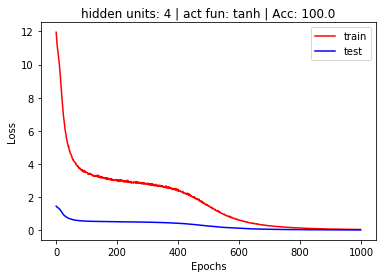

In [62]:
# %%time

# Train NN
num_epochs = 1000

# loss values
train_loss = np.zeros((num_epochs,1))
test_loss = np.zeros((num_epochs,1))

# threshold for stop epochs
threshold = 10000 # Find value

# plot for errors values
fig, ax = plt.subplots()
# fig.legend()

for epoch in range(num_epochs):
    
#     print(epoch)
    train_loss_tmp = 0
    test_loss_tmp = 0
    
    # training
    for data_train in torch_train_loader:

#         # CPU implementation
#         x_train, y_train = data_train
        
        # GPU implementation
        x_train, y_train = data_train[0].to(device), data_train[1].to(device)
        
#         x_train, y_train = x_train.to(device), y_train.to(device)
        
        # forward
        outputs = model(x_train)
        
        optimizer.zero_grad()
        
        loss = criterion(outputs, y_train.long())
        
        # update train loss
        train_loss_tmp += loss.item()
        
        # Backward and optimze
        loss.backward()
        optimizer.step()   
        
    # testing
    for data_test in torch_valid_loader:

#         # CPU implementation
#         x_test, y_test = data_test

        # GPU implementation
        x_test, y_test = data_test[0].to(device), data_test[1].to(device)
        
        # forward
        outputs = model(x_test)
        
        loss = criterion(outputs, y_test.long())
        
        # update train loss
        test_loss_tmp += loss.item()
    
#     print('Finish epoch {0}\n'.format(epoch))
    
    train_loss[epoch] = train_loss_tmp
    test_loss[epoch] = test_loss_tmp
    
    # Compare erros, if they are greather than threshold so stop
    if (test_loss_tmp - train_loss_tmp) > threshold:
        
        print('Stop because differences between errors is greather than {0}'.format(threshold))
        break
    
#     print('Finish iteration in epoch')
#     print(train_loss)
#     Plot test errors

ax.plot(train_loss[0:epoch], color = 'red', label = 'train')
ax.plot(test_loss[0:epoch], color = 'blue', label = 'test')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')


# Test NN
with torch.no_grad():
    
    correct = 0
    total = 0
    
    for data_test in torch_valid_loader:
        
#         # CPU implementation
#         x_test, y_test = data_test
        
        # GPU implementation
        x_test, y_test = data_test[0].to(device), data_test[1].to(device)
        
        outputs = model(x_test)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += y_test.size(0)
        
        correct += (predicted == y_test.long()).sum().item()
        
    print('Accuracy: {0}'.format(correct/total*100))   
    

title = 'hidden units: ' + str(num_hidden) + ' | act fun: ' + act_function + ' | Acc: ' +  str(correct/total*100)
ax.title.set_text(title)
# Save plot
fig.savefig(title + '.png')

In [68]:
# Test NN
with torch.no_grad():
    
    correct = 0
    total = 0
    
    for data_ in torch_train_loader:
        
#         # CPU implementation
#         x_test, y_test = data_test
        
        # GPU implementation
        x_test, y_test = data_test[0].to(device), data_test[1].to(device)
        
        outputs = model(x_test)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += y_test.size(0)
        
        correct += (predicted == y_test.long()).sum().item()
        
    print('Accuracy: {0}'.format(correct/total*100))    

Accuracy: 55.32786885245902
